In [4]:
# Q1 – EDA & Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# 1. Load dataset
df = pd.read_csv("2024272.csv")
print("Shape:", df.shape)
display(df.head())

# 2. Basic info
display(df.info())
print("\nMissing values:\n", df.isnull().sum())

# 3. Descriptive statistics
display(df.describe(include='all').T)

# 4. Separate numeric and categorical
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# 5. Handle missing values
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

# 6. Outlier detection (IQR)
for c in num_cols:
    Q1, Q3 = df[c].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = ((df[c] < lower) | (df[c] > upper)).sum()
    print(f"{c}: {outliers} outliers")

# 7. Encoding categorical variables
encoder = OrdinalEncoder()
if cat_cols:
    df[cat_cols] = encoder.fit_transform(df[cat_cols])

# 8. Scaling numeric features
# Exclude the target variable 'churn' from scaling
numeric_features_to_scale = [col for col in num_cols if col != 'churn']
scaler = StandardScaler()
df[numeric_features_to_scale] = scaler.fit_transform(df[numeric_features_to_scale])

print("\nPreprocessing completed ✅")
display(df.head())

Shape: (552, 8)


,state,city,educational_attainment,house_ownership,marital_status,age,gender,churn
0,KA,NaN,High School,No,Married,56.964924,Female,0
1,AP,Hyderabad,Bachelor,Yes,Married,47.298858,Female,1
2,KA,Bangalore,Master,No,Divorced,71.970225,Male,0
3,AP,Bangalore,PhD,No,NaN,63.976785,Male,1
4,KA,NaN,High School,No,Married,57.412563,Female,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   522 non-null    object 
 1   city                    518 non-null    object 
 2   educational_attainment  552 non-null    object 
 3   house_ownership         527 non-null    object 
 4   marital_status          524 non-null    object 
 5   age                     552 non-null    float64
 6   gender                  525 non-null    object 
 7   churn                   552 non-null    int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 34.6+ KB


None


Missing values:
 state                     30
city                      34
educational_attainment     0
house_ownership           25
marital_status            28
age                        0
gender                    27
churn                      0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
state,522,5,TN,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,518,5,Kolkota,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
educational_attainment,552,4,PhD,149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
house_ownership,527,2,No,265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,524,4,Divorced,145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,552.0,NaN,NaN,NaN,40.657623,12.4373,18.0,31.78872,40.23963,48.375979,112.809192
gender,525,2,Male,278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
churn,552.0,NaN,NaN,NaN,0.514493,0.500243,0.0,0.0,1.0,1.0,1.0


Numeric columns: ['age', 'churn']
Categorical columns: ['state', 'city', 'educational_attainment', 'house_ownership', 'marital_status', 'gender']
age: 6 outliers
churn: 0 outliers

Preprocessing completed ✅


,state,city,educational_attainment,house_ownership,marital_status,age,gender,churn
0,1.0,3.0,1.0,0.0,1.0,1.312350,0.0,0
1,0.0,2.0,0.0,1.0,1.0,0.534462,0.0,1
2,1.0,0.0,2.0,0.0,0.0,2.519920,1.0,0
3,0.0,0.0,3.0,0.0,0.0,1.876638,1.0,1
4,1.0,3.0,1.0,0.0,1.0,1.348374,0.0,1


In [5]:
# Q2 – Modelling Experiments
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif

# 1. Select target column (change if different)
target = "churn"  # <- replace with your target if different
assert target in df.columns, "Check your target column name!"
X = df.drop(columns=[target])
y = df[target]

# 2. Feature selection (mutual info)
mi = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
top5 = mi_scores.index[:5]
top10 = mi_scores.index[:10]
print("Top 10 important features:\n", top10.tolist())

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def evaluate(model, name, option):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    metrics = {
        'model': name,
        'option': option,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1': f1_score(y_test, preds),
        'roc_auc': roc_auc_score(y_test, proba) if proba is not None else None
    }
    return metrics

results = []

# Naive Bayes experiments
for features in [top5, top10, X.columns]:
    nb = GaussianNB()
    results.append(evaluate(nb, "Naive Bayes", f"{len(features)} features"))

# kNN experiments with different k
for k in [3, 5, 9]:
    knn = KNeighborsClassifier(n_neighbors=k)
    results.append(evaluate(knn, f"kNN (k={k})", "All features"))

# Compare results
results_df = pd.DataFrame(results).sort_values(by='accuracy', ascending=False)
display(results_df)

best_model_info = results_df.iloc[0]
print("\n✅ Best Model:")
print(best_model_info)

Top 10 important features:
 ['house_ownership', 'city', 'state', 'educational_attainment', 'marital_status', 'age', 'gender']


,model,option,accuracy,precision,recall,f1,roc_auc
0,Naive Bayes,5 features,0.668675,0.650000,0.764706,0.702703,0.655338
1,Naive Bayes,7 features,0.668675,0.650000,0.764706,0.702703,0.655338
2,Naive Bayes,7 features,0.668675,0.650000,0.764706,0.702703,0.655338
3,kNN (k=3),All features,0.566265,0.574713,0.588235,0.581395,0.555991
4,kNN (k=5),All features,0.548193,0.556818,0.576471,0.566474,0.547712
5,kNN (k=9),All features,0.530120,0.539326,0.564706,0.551724,0.562092



✅ Best Model:
model        Naive Bayes
option        5 features
accuracy        0.668675
precision           0.65
recall          0.764706
f1              0.702703
roc_auc         0.655338
Name: 0, dtype: object


,decile,count,positives,avg_proba,cum_positives,cum_rate,response_rate,lift
0,1,17,5,0.315034,5,0.058824,0.294118,0.574394
1,2,17,6,0.400196,11,0.129412,0.352941,0.689273
2,3,16,4,0.442604,15,0.176471,0.250000,0.488235
3,4,17,6,0.480795,21,0.247059,0.352941,0.689273
4,5,16,11,0.521166,32,0.376471,0.687500,1.342647
5,6,17,11,0.553459,43,0.505882,0.647059,1.263668
6,7,16,11,0.576827,54,0.635294,0.687500,1.342647
7,8,17,13,0.607063,67,0.788235,0.764706,1.493426
8,9,16,6,0.642912,73,0.858824,0.375000,0.732353
9,10,17,12,0.681506,85,1.000000,0.705882,1.378547


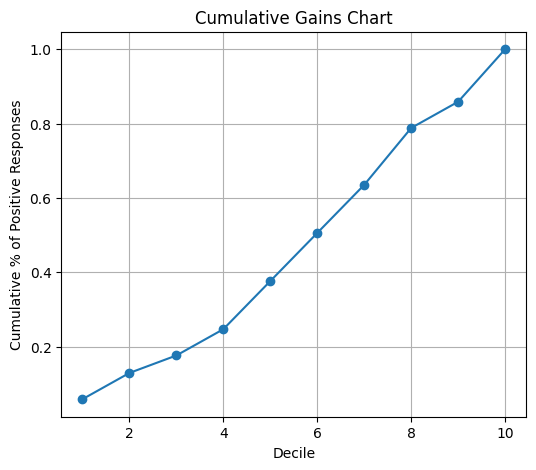

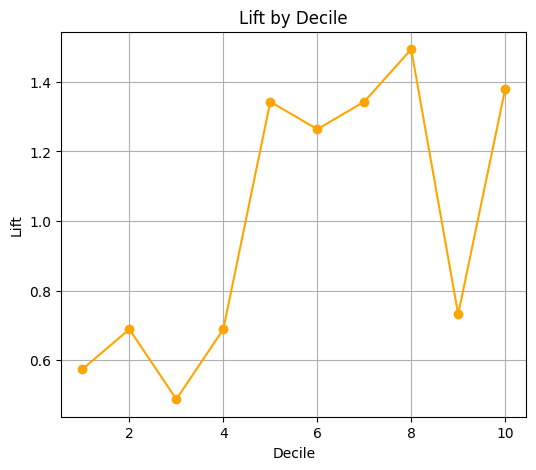

In [6]:
# Q3 – Lift Chart and Cumulative Gains for the best model
from sklearn.metrics import roc_curve

# Refit best model
best_name = best_model_info['model']
if "Naive" in best_name:
    final_model = GaussianNB()
else:
    k = int(best_name.split('=')[1].split(')')[0]) if 'k=' in best_name else 5
    final_model = KNeighborsClassifier(n_neighbors=k)

final_model.fit(X_train, y_train)
probs = final_model.predict_proba(X_test)[:,1]
test = pd.DataFrame({'y': y_test, 'proba': probs}).sort_values('proba', ascending=False)
test['decile'] = pd.qcut(test['proba'], 10, labels=False, duplicates='drop') + 1

# Lift & Gain calculations
gain_table = test.groupby('decile').agg({'y':['count','sum'],'proba':'mean'}).reset_index()
gain_table.columns = ['decile','count','positives','avg_proba']
gain_table = gain_table.sort_values('decile', ascending=True)
gain_table['cum_positives'] = gain_table['positives'].cumsum()
gain_table['cum_rate'] = gain_table['cum_positives'] / gain_table['positives'].sum()
gain_table['response_rate'] = gain_table['positives'] / gain_table['count']
gain_table['lift'] = gain_table['response_rate'] / (gain_table['positives'].sum() / len(test))

display(gain_table)

# Cumulative Gain Chart
plt.figure(figsize=(6,5))
plt.plot(gain_table['decile'], gain_table['cum_rate'], marker='o')
plt.title('Cumulative Gains Chart')
plt.xlabel('Decile')
plt.ylabel('Cumulative % of Positive Responses')
plt.grid(True)
plt.show()

# Lift Chart
plt.figure(figsize=(6,5))
plt.plot(gain_table['decile'], gain_table['lift'], marker='o', color='orange')
plt.title('Lift by Decile')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.grid(True)
plt.show()
